# Step 1 - Destiny 2 Stats - Load Aggregated Stats

En este cuaderno se cargan los datos de configuración creados en el cuaderno del paso 0 y se emplean para obtener y analizar la información de datos agregados de crisol que ofrece el API de Bungie.

In [1]:
import requests
import json
import os
import pandas as pd
import base64
import urllib
from calendar import monthrange
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Especificar el APIKey y el nombre del jugador

Se lee información generada en el paso 0.

In [2]:
configfile = open("config/setup.json","r+")
configstr = configfile.readlines()
if len(configstr) > 0:
    config = json.loads(configstr[0])
configfile.close()

### A continuación se definen algunas funciones necesarias más adelante

In [3]:
# Carpeta auxiliar para almacenar los ficheros temporales
def requestWithCache(method, url, headers, data, verbose = False):
    cacheFolder = 'DestinyTemp'
    cacheFile = 'cache-1.json'

    if not os.path.exists(cacheFolder):
        os.makedirs(cacheFolder)
    
    cachePath = cacheFolder + "/" + cacheFile
    
    #recuperamos la cache
    cache = {}
    if os.path.isfile(cachePath):
        cachef = open(cachePath,"r+")
        cached = cachef.readlines()
        if len(cached) > 0:
            cache = json.loads(cached[0])
        cachef.close()    
    
    r = ""
    
    if method == "GET":
        cachekey = url #base64.urlsafe_b64encode(bytes(url, 'utf-8')).decode('ascii')
        if cachekey in cache:
            if verbose:
                print("cache found " + cachekey)
            r = cache[cachekey]            
        else:
            if verbose:
                print("cache not found " + cachekey)
            response = requests.request(method, url = url, headers=headers, data=data)
            r = response.text
            #grabamos la cache
            cache[cachekey] = r
            cachef = open(cachePath,"w+")
            cachef.write(json.dumps(cache))
            cachef.close()
    else:
        if verbose:
            print("cache not apply")
        r = requests.request(method, url = url, headers=headers, data=data)
    
        
    cachef.close()
    
    return r

In [4]:
# https://bungie-net.github.io/#Destiny2.GetHistoricalStats
def getCharacterStats(daystart, dayend, membershipType, membershipId, characterId):
    #groups = ""
    #modes = "69,70" #competitivo, quickplay
    modes = "10,12,15,19,31,37,38,39,48,59,80,84" #Destiny.HistoricalStats.Definitions.DestinyActivityModeType
    period = "daily" #algunos modos no aparecen porque no ofrecen información segmentada pro dias, solo allTime, com ironbanner

    url = "https://www.bungie.net/Platform/Destiny2/" + membershipType + "/Account/" + membershipId + "/Character/" + characterId + "/Stats"
    
    url += "?daystart=" + daystart
    url += "&dayend=" + dayend
    url += "&modes=" + modes
    url += "&period=" + period

    headers = { 'X-API-Key': config["ApiKey"] }
    #response = requests.request("GET", url, headers=headers, data=payload)
    response = requestWithCache(method = "GET", url = url, headers = headers, data = {})

    data = json.loads(response)
    initialized = False
    dfi = 0
    dfdata = pd.DataFrame(columns=[])
    # convierto el json en un dataframe
    for imode, mode in enumerate(data["Response"]):
        daydata = data["Response"][mode]
        if "daily" in data["Response"][mode]:
            daydata = data["Response"][mode]["daily"]
            for iday,day in enumerate(daydata):
                columns = ["period", "mode"]
                values = [day["period"], mode]
                for i,c in enumerate(day["values"]):
                    columns = columns + [c]
                    values = values + [day["values"][c]["basic"]["value"]]
                if initialized == False:
                    #dfcolumns = columns
                    dfdata = pd.DataFrame(columns=columns)
                    initialized = True
                dfi += 1
                dfdata.loc[dfi] = values
    
    if 'period' in dfdata.columns:
        dfdata['period'] = dfdata['period'].astype('datetime64[ns]')
        dfdata['period_month'] = dfdata['period'].dt.strftime("%Y%m")
        dfdata['period_week'] = dfdata['period'].dt.strftime("%Y%V")
    
    return dfdata

In [5]:
# creamos unos iteradores para recorrer los datos en un rango de fechas
def month_year_iter( start_month, start_year, end_month, end_year ):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for ym in range( ym_start, ym_end ):
        y, m = divmod( ym, 12 )
        yield y, m+1

In [6]:
#recuperamos las estadisticas mes a mes

startYear = 2020
startMonth = 1
endYear   = 2021
endMonth  = 4

stats = pd.DataFrame(index=[], columns=[])

for y,m in month_year_iter(startMonth,startYear,endMonth,endYear):
    daystart= str(y)+"-"+str(m).zfill(2)+"-01"
    dayend  = str(y)+"-"+str(m).zfill(2)+"-"+str(monthrange(y,m)[1]).zfill(2)
    monthstats = getCharacterStats(daystart=daystart, dayend=dayend, membershipType = config["membership"]["membershipType"], membershipId = config["membership"]["membershipId"], characterId = config["character"]["characterId"])
    print(monthstats.shape)
    stats = pd.concat([stats, monthstats], ignore_index=True)
    
meaningful_columns = [
"period", #dia
"mode", #modo de juego
"activitiesEntered", #actividades jugadas ese dia
"assists", #suma de asistencias ese dia
"kills", #numero de ultimos golpes ese dia
"averageKillDistance", #media de metros en los que se hizo el ultimo golpe ese dia
"secondsPlayed", #segundos jugados ese dia 
"deaths", #suma de muertes de ese dia
"averageLifespan", #tiempo medio de por vida
"score", #parece la suma de puntos obtenidos en la partidas ese dia, solo disponible en algunas partidas (p.ej. control)
"efficiency", #media de eficiencia en combate en las partidas de ese dia
"killsDeathsRatio", #media de bajas por muertes de ese dia
"killsDeathsAssists", #media de bajas y asistencias por muertes ese dia
"precisionKills", #suma de disparos de precisión en las partidas de ese dia
"resurrectionsPerformed", #suma de resurecciones realizadas ese dia
"resurrectionsReceived", #suma de resurecciones recibidas ese dia
"suicides", #suma de suicidios ese dia
"winLossRatio", #victorias entre derrotas de ese dia
"combatRating", #rating de combate de ese dia, lo asigna bungie en base a lo bien que lo has hecho...
"period_month", #para agregar por meses
"period_week" #para agregar por semanas               
]

stats = stats[meaningful_columns]
stats


(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(56, 41)
(48, 41)
(21, 41)
(24, 41)
(16, 41)
(20, 41)


,period,mode,activitiesEntered,assists,kills,averageKillDistance,secondsPlayed,deaths,averageLifespan,score,...,killsDeathsRatio,killsDeathsAssists,precisionKills,resurrectionsPerformed,resurrectionsReceived,suicides,winLossRatio,combatRating,period_month,period_week
0,2020-10-06,control,1.0,2.0,6.0,14.166667,572.0,11.0,47.666667,17.0,...,0.545455,0.636364,1.0,0.0,0.0,0.0,0.000000,84.658906,202010,202041
1,2020-10-07,control,2.0,6.0,17.0,10.882353,1281.0,22.0,55.695652,43.0,...,0.772727,0.909091,2.0,0.0,0.0,0.0,1.000000,101.985842,202010,202041
2,2020-10-08,control,4.0,8.0,27.0,8.703704,2662.0,41.0,63.380952,72.0,...,0.658537,0.756098,3.0,0.0,0.0,1.0,0.000000,99.120884,202010,202041
3,2020-10-09,control,3.0,8.0,14.0,9.785714,1943.0,28.0,67.000000,36.0,...,0.500000,0.642857,3.0,0.0,0.0,0.0,2.000000,58.170246,202010,202041
4,2020-10-11,control,2.0,10.0,7.0,8.428571,1301.0,22.0,56.565217,29.0,...,0.318182,0.545455,1.0,0.0,0.0,0.0,1.000000,69.152530,202010,202041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2021-03-24,survival,8.0,12.0,34.0,13.529412,4103.0,63.0,64.109375,0.0,...,0.539683,0.634921,8.0,0.0,0.0,0.0,0.333333,0.000000,202103,202112
181,2021-03-26,survival,1.0,7.0,11.0,12.181818,905.0,8.0,100.555556,0.0,...,1.375000,1.812500,2.0,0.0,0.0,0.0,-1.000000,0.000000,202103,202112
182,2021-03-28,survival,1.0,1.0,8.0,21.875000,726.0,12.0,55.846154,0.0,...,0.666667,0.708333,1.0,0.0,0.0,0.0,-1.000000,0.000000,202103,202112
183,2021-03-31,survival,1.0,3.0,7.0,22.000000,861.0,9.0,86.100000,0.0,...,0.777778,0.944444,2.0,0.0,0.0,0.0,-1.000000,0.000000,202103,202113


In [7]:
# Funciones de representación de datos
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def draw_boxplot(df, column, period = "period_month", offset = 0):
    columns = []
    values = []

    stats_per_period = df[[period,column]].groupby([period])
    for group in stats_per_period.groups:
        #stats_per_period.get_group(group) 
        columns.append(group)
        values.append(stats_per_period.get_group(group)[column].tolist())

    p = plt.boxplot(values, labels=columns, positions=np.array(range(len(values)))*2.0+offset, sym='', widths=0.6)
    return p

def draw_comparison_boxplot(column):
    plt.figure()

    bpl = draw_boxplot(df = stats[stats["mode"] == "control"], column = column, offset=-0.4)
    bpr = draw_boxplot(df = stats[stats["mode"] == "survival"], column = column, offset=0.4)

    set_box_color(bpl, '#D7191C')
    set_box_color(bpr, '#2C7BB6')

    plt.plot([], c='#D7191C', label='control')
    plt.plot([], c='#2C7BB6', label='survival')

    plt.legend()

In [8]:
stats.describe()

,activitiesEntered,assists,kills,averageKillDistance,secondsPlayed,deaths,averageLifespan,score,efficiency,killsDeathsRatio,killsDeathsAssists,precisionKills,resurrectionsPerformed,resurrectionsReceived,suicides,winLossRatio,combatRating
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,3.962162,12.729730,27.097297,15.857783,2445.589189,34.005405,72.665290,39.048649,1.283644,0.856221,1.069933,6.708108,0.302703,0.270270,0.221622,0.690321,98.898464
std,3.137029,11.058266,21.698558,4.217593,1808.784318,25.508630,21.420871,57.073968,0.580571,0.384423,0.468563,6.911804,1.270588,1.269386,0.589369,1.415291,124.415012
min,1.000000,0.000000,0.000000,0.000000,137.000000,1.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,2.000000,5.000000,13.000000,13.170213,1132.000000,14.000000,56.309524,0.000000,0.915254,0.600000,0.736842,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,10.000000,21.000000,15.578947,1961.000000,28.000000,70.000000,16.000000,1.209877,0.777778,1.025000,5.000000,0.000000,0.000000,0.000000,0.500000,84.658906
75%,5.000000,16.000000,36.000000,18.666667,3316.000000,45.000000,86.100000,54.000000,1.555556,1.080000,1.291667,9.000000,0.000000,0.000000,0.000000,1.000000,119.606924
max,22.000000,66.000000,110.000000,31.000000,12030.000000,158.000000,163.285714,289.000000,3.600000,2.000000,2.700000,40.000000,8.000000,11.000000,5.000000,7.000000,1133.245973


In [9]:
stats[["activitiesEntered","killsDeathsRatio","efficiency", "score"]]

,activitiesEntered,killsDeathsRatio,efficiency,score
0,1.0,0.545455,0.727273,17.0
1,2.0,0.772727,1.045455,43.0
2,4.0,0.658537,0.853659,72.0
3,3.0,0.500000,0.785714,36.0
4,2.0,0.318182,0.772727,29.0
...,...,...,...,...
180,8.0,0.539683,0.730159,0.0
181,1.0,1.375000,2.250000,0.0
182,1.0,0.666667,0.750000,0.0
183,1.0,0.777778,1.111111,0.0


In [10]:
#calculamos variables derivadas haciendo los valores sumatorios relativos al numero de partidas jugadas
stats["averageAssists"] = stats["assists"] / stats["activitiesEntered"]
stats["averageKills"] = stats["kills"] / stats["activitiesEntered"]
stats["averageDeaths"] = stats["deaths"] / stats["activitiesEntered"]
stats["averageScore"] = stats["score"] / stats["activitiesEntered"]
stats["averagePrecisionKills"] = stats["precisionKills"] / stats["activitiesEntered"]
stats["averageResurrectionsPerformed"] = stats["resurrectionsPerformed"] / stats["activitiesEntered"]
stats["averageResurrectionsReceived"] = stats["resurrectionsReceived"] / stats["activitiesEntered"]
stats["averageSuicides"] = stats["suicides"] / stats["activitiesEntered"]

meaningful_columns = [
    "averageAssists",
    "averageKills",
    "averageDeaths",
    "averageScore",
    "averagePrecisionKills",
    "averageResurrectionsPerformed",
    "averageResurrectionsReceived",
    "averageSuicides",
    "averageKillDistance", #media de metros en los que se hizo el ultimo golpe ese dia
    "averageLifespan", #tiempo medio de por vida
    "efficiency", #media de eficiencia en combate en las partidas de ese dia
    "killsDeathsRatio", #media de bajas por muertes de ese dia K/D
    "killsDeathsAssists", #media de bajas y asistencias por muertes ese dia (K+A/2)/D
    "winLossRatio", #victorias entre derrotas de ese dia
    "combatRating", #rating de combate de ese dia, lo asigna bungie en base a lo bien que lo has hecho...
    "period_month", #para agregar por meses
    "period_week" #para agregar por semanas               
]

stats[meaningful_columns]
monthaggstats = stats[meaningful_columns].groupby(['period_month']).mean()
weekaggstats = stats[meaningful_columns].groupby(['period_week']).mean()

weekaggstats


,averageAssists,averageKills,averageDeaths,averageScore,averagePrecisionKills,averageResurrectionsPerformed,averageResurrectionsReceived,averageSuicides,averageKillDistance,averageLifespan,efficiency,killsDeathsRatio,killsDeathsAssists,winLossRatio,combatRating
period_week,,,,,,,,,,,,,,,
202040,2.700000,4.404545,7.190909,13.668182,0.863636,0.000000,0.000000,0.022727,13.270150,84.316675,0.988045,0.612518,0.800281,1.250000,82.884773
202041,3.620525,5.649228,8.844136,12.789352,1.055247,0.111111,0.000000,0.075617,13.046382,69.553619,1.093109,0.657190,0.875150,0.848148,130.798769
202042,4.599634,6.715812,8.000549,14.630586,0.844261,0.000000,0.000000,0.019536,14.217411,79.120511,1.503412,0.875208,1.189310,0.320513,139.980665
202043,3.385417,7.685417,9.254167,10.447917,0.756250,0.072917,0.052083,0.087500,13.268512,74.068207,1.220824,0.843845,1.032335,0.761364,195.190703
202044,2.623856,7.285948,8.982026,9.423856,1.317974,0.117647,0.058824,0.068627,13.950321,70.419263,1.089806,0.807971,0.948889,0.306468,154.245790
202045,1.040728,6.469683,8.387092,2.450570,0.949229,0.074510,0.138562,0.013889,18.137040,75.968633,0.908768,0.773012,0.840890,0.614528,223.156608
202046,3.539048,7.082857,9.964286,9.169048,2.573333,0.000000,0.000000,0.028571,14.403612,75.772743,1.206496,0.822226,1.014361,1.316667,82.608547
202047,3.451160,6.842796,9.359585,9.731685,2.545177,0.000000,0.000000,0.087607,16.609592,71.974444,1.268103,0.803797,1.035950,0.382051,55.290866
202048,3.788889,7.604167,9.156944,7.830556,3.027778,0.000000,0.000000,0.037500,19.647603,74.438168,1.253517,0.839403,1.046460,0.444444,38.335028


In [11]:
stats[["period","mode","activitiesEntered","kills","assists"]][(stats["activitiesEntered"] >2) & (stats["period"] > '2021-03-15')]

,period,mode,activitiesEntered,kills,assists
166,2021-03-16,control,8.0,47.0,24.0
167,2021-03-17,control,9.0,110.0,57.0
169,2021-03-19,control,4.0,43.0,16.0
171,2021-03-21,control,5.0,63.0,37.0
172,2021-03-22,control,9.0,98.0,50.0
173,2021-03-30,control,9.0,92.0,46.0
174,2021-03-31,control,4.0,25.0,29.0
180,2021-03-24,survival,8.0,34.0,12.0


<img src="Resources/control-quickplay-destinytracker.JPG" width="700px">

In [12]:
weekaggstats.describe()

,averageAssists,averageKills,averageDeaths,averageScore,averagePrecisionKills,averageResurrectionsPerformed,averageResurrectionsReceived,averageSuicides,averageKillDistance,averageLifespan,efficiency,killsDeathsRatio,killsDeathsAssists,winLossRatio,combatRating
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,3.554126,7.080262,8.798698,9.294275,1.782420,0.077317,0.063790,0.061229,16.311222,74.420402,1.291814,0.861319,1.076566,0.655725,78.897225
std,0.990916,1.585607,1.527297,5.589601,0.784279,0.169512,0.178463,0.098449,2.411299,10.889949,0.247947,0.164919,0.199805,0.654431,65.591631
min,1.040728,3.600000,3.900000,0.000000,0.666667,0.000000,0.000000,0.000000,13.046382,48.647972,0.908768,0.592437,0.778361,-1.000000,0.000000
25%,3.177083,6.039286,7.986386,7.279762,1.110957,0.000000,0.000000,0.000000,14.310511,69.456783,1.091458,0.775144,0.913980,0.313490,38.837853
50%,3.626667,7.079365,8.990476,9.423856,1.619048,0.000000,0.000000,0.028571,15.687374,71.974444,1.268103,0.863636,1.067368,0.666667,55.290866
75%,3.965476,7.904894,9.487121,12.186343,2.474435,0.073713,0.055453,0.083333,18.045793,80.492074,1.409406,0.974009,1.178536,0.926587,100.677520
max,5.343182,11.000000,11.250000,19.803571,3.143333,0.700000,0.900000,0.500000,20.835726,99.675000,1.967657,1.208234,1.587945,2.466667,245.350038


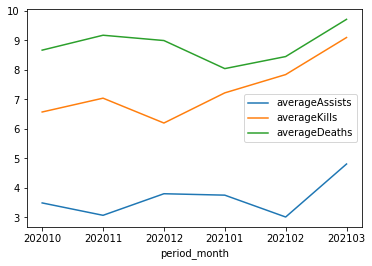

In [13]:
monthaggstats[["averageAssists","averageKills",'averageDeaths']].plot.line();

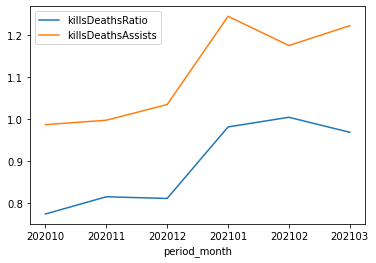

In [14]:
monthaggstats[["killsDeathsRatio","killsDeathsAssists"]].plot.line();

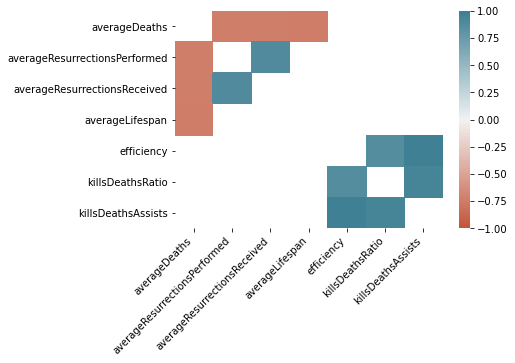

In [15]:
#calculamos las correlaciones
correlation_df = weekaggstats.corr(method='pearson')#, 'pearson',‘kendall’, ‘spearman’) #calculamos la correlación de pearson

#mostramos la correlacion
for c in correlation_df.columns:
    correlation_df[c] = correlation_df[c].apply(lambda x: x if abs(x) > 0.7 else np.NaN) #aplicamos un threshold
    correlation_df[c][c] = np.NaN # quitamos las correlaciones con la misma columna, no aportan info

correlation_df = correlation_df.dropna(axis=1, how='all') #eliminamos las columnas donde todos son nan
correlation_df = correlation_df.dropna(axis=0, how='all') #eliminamos las filas donde todos son nan
correlation_df

ax = sns.heatmap(correlation_df, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


In [16]:
weekaggstats[['averageKillDistance', 'efficiency', 'winLossRatio', ]].corr()

,averageKillDistance,efficiency,winLossRatio
averageKillDistance,1.000000,0.251146,0.002456
efficiency,0.251146,1.000000,-0.121343
winLossRatio,0.002456,-0.121343,1.000000


<AxesSubplot:xlabel='averageKillDistance', ylabel='efficiency'>

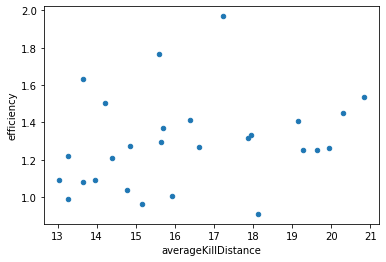

In [17]:
weekaggstats.plot.scatter(x='averageKillDistance', y='efficiency')

In [18]:
weekaggstats[["averageKillDistance", "efficiency", 'winLossRatio', "killsDeathsRatio","killsDeathsAssists"]].corr()


,averageKillDistance,efficiency,winLossRatio,killsDeathsRatio,killsDeathsAssists
averageKillDistance,1.000000,0.251146,0.002456,0.431961,0.334100
efficiency,0.251146,1.000000,-0.121343,0.868301,0.978822
winLossRatio,0.002456,-0.121343,1.000000,-0.095389,-0.114657
killsDeathsRatio,0.431961,0.868301,-0.095389,1.000000,0.951458
killsDeathsAssists,0.334100,0.978822,-0.114657,0.951458,1.000000


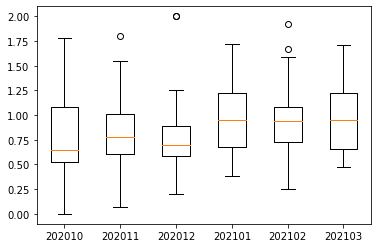

In [19]:
# comparr competitivo con no competitivo

columns = []
values = []

column = "killsDeathsRatio"
period = "period_month"

stats_per_period = stats[[period,column]].groupby([period])
for group in stats_per_period.groups:
    #stats_per_period.get_group(group) 
    columns.append(group)
    values.append(stats_per_period.get_group(group)[column].tolist())

plt.boxplot(values, labels=columns)
plt.show()
#df = pd.DataFrame(values, columns=columns)
#boxplot = df.boxplot(column=columns.index.tolist())

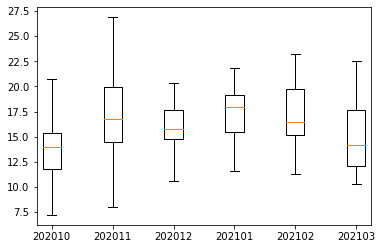

In [20]:
plt.figure()
bpl = draw_boxplot(df = stats, column = "averageKillDistance")

# comparando competitivo vs quickplay

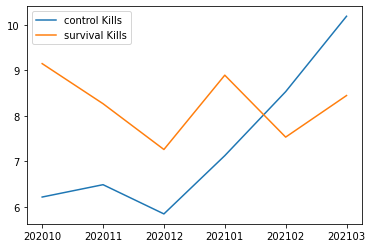

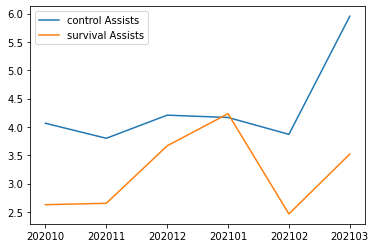

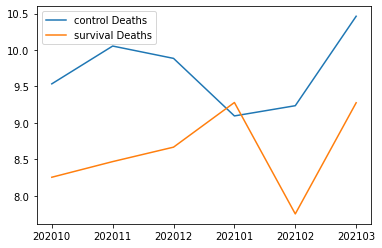

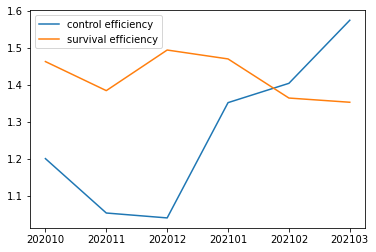

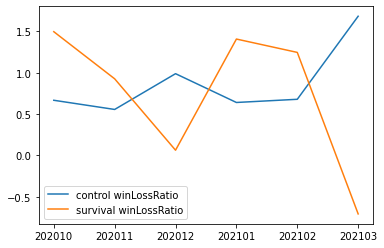

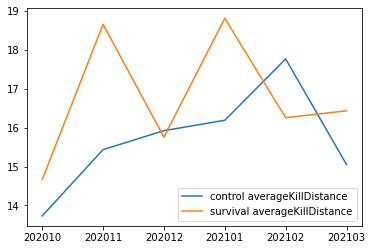

In [21]:
controlStats = stats[stats["mode"] == "control"][meaningful_columns].groupby(['period_month']).mean()
survivalStats = stats[stats["mode"] == "survival"][meaningful_columns].groupby(['period_month']).mean()

#plt.plot(controlStats["averageKills"], survivalStats["averageKills"])
plt.plot(controlStats["averageKills"], label = "control Kills")
plt.plot(survivalStats["averageKills"], label = "survival Kills")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

plt.plot(controlStats["averageAssists"], label = "control Assists")
plt.plot(survivalStats["averageAssists"], label = "survival Assists")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

plt.plot(controlStats["averageDeaths"], label = "control Deaths")
plt.plot(survivalStats["averageDeaths"], label = "survival Deaths")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

plt.plot(controlStats["efficiency"], label = "control efficiency")
plt.plot(survivalStats["efficiency"], label = "survival efficiency")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

plt.plot(controlStats["winLossRatio"], label = "control winLossRatio")
plt.plot(survivalStats["winLossRatio"], label = "survival winLossRatio")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

plt.plot(controlStats["averageKillDistance"], label = "control averageKillDistance")
plt.plot(survivalStats["averageKillDistance"], label = "survival averageKillDistance")
#plt.plot(y, x, label = "line 2")
plt.legend()
plt.show()

#controlStats[["averageAssists","averageKills",'averageDeaths']].plot.line();
#survivalStats[["averageAssists","averageKills",'averageDeaths']].plot.line();

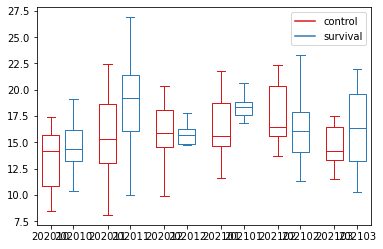

In [22]:
draw_comparison_boxplot(column="averageKillDistance")

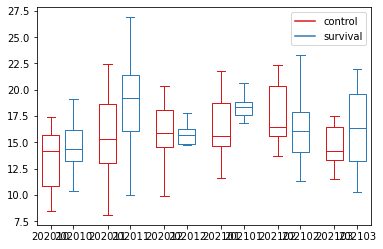

In [23]:
draw_comparison_boxplot(column="averageKillDistance")

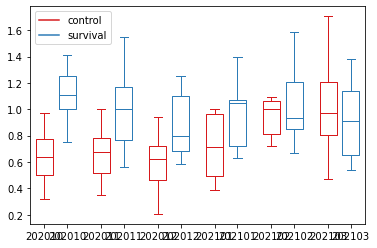

In [24]:
draw_comparison_boxplot(column="killsDeathsRatio")